In [1]:
#import requests as req
import io
from urllib.request import urlopen, Request
import requests
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os
import sqlite3 as sql
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
from wordcloud import WordCloud , ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
import textblob
from googletrans import Translator
translator = Translator()
from google_trans_new import google_translator  
import nltk
import string
import re

import turkishnlp
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import nltk as nlp
from PIL import Image

from string import punctuation, digits
#from snowballstemmer import TurkishStemmer
#https://pypi.org/project/TurkishStemmer/
from TurkishStemmer import TurkishStemmer
from nltk import word_tokenize
nltk.download('punkt')
from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Machine Learning imports
from nltk.util import ngrams
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
#SAVE MODEL
import pickle

In [4]:
engine = create_engine('sqlite:///Vestel_database.db', echo=True)
sqlite_connection = engine.connect()


In [5]:
eksisozluk_list = []
twitter_df = []
shiftdelete_df=[]

df = pd.read_sql_query("SELECT Date_time,Text from eksisozluk_list", sqlite_connection)
df_twit= pd.read_sql_query("SELECT Date_time,Text from Tweet_list", sqlite_connection)
df_shift= pd.read_sql_query("SELECT Date_time,Text from shiftdelete_list", sqlite_connection)

# Creating a dataframe from the tweets list above
eksisozluk_df = pd.DataFrame(df, columns=['Date_time', 'Text'])
#ADD TWITTER DATA TO DATAFRAME
twitter_df = pd.DataFrame(df_twit, columns=['Date_time','Text'])
#ADD TWITTER DATA TO DATAFRAME
shiftdelete_df = pd.DataFrame(df_shift, columns=['Date_time','Text'])

#eksisozluk_df.append(shiftdelete_df,ignore_index=True, sort=False)
comments_df=eksisozluk_df.append(twitter_df,ignore_index=True, sort=False)


2021-08-25 11:05:08,098 INFO sqlalchemy.engine.Engine SELECT Date_time,Text from eksisozluk_list
2021-08-25 11:05:08,100 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-25 11:05:08,109 INFO sqlalchemy.engine.Engine SELECT Date_time,Text from Tweet_list
2021-08-25 11:05:08,110 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-25 11:05:08,832 INFO sqlalchemy.engine.Engine SELECT Date_time,Text from shiftdelete_list
2021-08-25 11:05:08,835 INFO sqlalchemy.engine.Engine [raw sql] ()


In [6]:
yorumlar_df=comments_df.append(shiftdelete_df,ignore_index=True, sort=False)

In [7]:
yorumlar_df

,Date_time,Text
0,02.05.2019 17:55,ötv zamminin arkasinda bu babadagli piyanist ş...
1,03.05.2019 00:17 ~ 00:18,çöpünü dahi kullanmadığım ve bundan sonra da k...
2,05.05.2019 22:41,2 buzdolabi2 tv2 camasir mak1 firin 1 supurge ...
3,17.05.2019 16:00,yaklaşık 1 yıl önce sba120 soundbar aldım. ald...
4,08.06.2019 14:39,cep telefonlarının dokunmatikleri 2000'li yıll...
...,...,...
82340,3 Ocak 2018,Öyle yani Bazıları reklam falan yaptırıyorlar ...
82341,3 Ocak 2018,vestel servisi iyi ki.
82342,14 Ocak 2018,ben Vestel kullandım ve şikayetçi değilim. Ves...
82343,2 Eyl 2018,Ben memnunum kişinin beklentisine göre olmalı


In [8]:
len(yorumlar_df)

82345

In [9]:
# load train data
#https://www.kaggle.com/burhanbilenn/duygu-analizi-icin-urun-yorumlari?select=magaza_yorumlari_duygu_analizi.csv
dataset_train = pd.read_csv('magaza_yorumlari_duygu_analizi.csv',sep=",",encoding ='utf-16')
                  
dataset_train=dataset_train[['Görüş', 'Durum']]

In [10]:
dataset_train.tail()

,Görüş,Durum
11433,Telefonu aldım haparlör den ses gelmiyor hicbi...,Olumsuz
11434,Yorum yapan arkadaşları gerçek den anlayamıyor...,Olumsuz
11435,yazılım olarak abuk subuk ufak hatalar dolu ve...,Olumsuz
11436,1 aydır kullanıyorum ön kamerası berbat arka k...,Olumsuz
11437,Daha önce ısınma problemi var diye yorum yapmı...,Tarafsız


In [11]:
#kaynak:https://stackoverflow.com/questions/50443494/error-in-removing-punctuation-float-object-has-no-attribute-translate
dataset_train['Görüş'] = dataset_train.fillna({'Görüş':''})

x_gorus=dataset_train['Görüş']
y_durum=dataset_train['Durum']

sentiment_ordering = ['Olumsuz', 'Tarafsız', 'Olumlu']
y_durum = y_durum.apply(lambda x: sentiment_ordering.index(x))

y_durum.head()

0    0
1    1
2    2
3    0
4    0
Name: Durum, dtype: int64

In [12]:
t_stopwords=[]
stop_words=set(stopwords.words('turkish'))
t_stopwords = open('turkish_stopwords.txt', 'r',encoding ='utf-8').read().split()
remove = ['VESTEL','...','“','”','Vestel','…','vestel','.....','vestelin','ve','bu','şu','’','bir']
stop_words.update(t_stopwords)
stop_words.update(remove)



def ozel_karakter (text):
    punctation = string.punctuation
    return text.translate(str.maketrans("","",punctation))

def token(values):
    
    words = word_tokenize(values)
    filtered_words = [word for word in words if (word not in stop_words)]
    #corrected_words=obj.auto_correct(filtered_words)
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

def stemming_tokenizer(text): 
    stemmer= TurkishStemmer()
    #text=[stemmer.stem(word) for word in word_tokenize(text)  if ( 'http' not in word)] 
    #text=" ".join(text)
    
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in word_tokenize(text)] # this code finds the root of the word for a word in the sentence and change them to their root form.
    text=" ".join(text)
    return text

def process_text(d): 
    
    emojis=re.compile("["
                     u"\U0001F600-\U0001F64F"
                     u"\U0001F300-\U0001F5FF" 
                     u"\U0001F680-\U0001F6FF"
                     u"\U0001F1E0-\U0001F1FF"
                     "]+",flags=re.UNICODE)
    #Convert @username and hastags
    d = d.apply(lambda x: re.sub("@[^\s]+", " ",x ))
    d = d.apply(lambda x: re.sub("#[^\s]+","", x))
    #lower() yapıldığı zaman I harfi i olarak çevirildiğinden dolayı replace ile düzeltildi.
    d = d.apply(lambda x: x.replace('İ','i'))
    d = d.apply(lambda x: x.lower().strip())
    d = d.apply(lambda x: re.sub(r'[0-9]+', '', x))
    d = d.apply(lambda x: x.replace('.....',' '))
    
    d = d.apply(lambda x: x.replace('\u200b', '').replace('\n', ''))
    d = d.apply(lambda x: ozel_karakter (x))
    d = d.apply(lambda x: re.sub('\W+', ' ', x))
    d = d.apply(lambda x: re.sub('&amp+', '&', x))
    d = d.apply(lambda x: re.sub("\d+", "", x))
    # Remove words with 2 or fewer letters
    d= d.apply(lambda x:  re.sub(r'\b\w{1,2}\b', '', x))
    # Remove whitespace (including new line characters)
    d= d.apply(lambda x: re.sub(r'\s\s+', ' ', x))
    # Remove HTML special entities (e.g. &amp;)
    d= d.apply(lambda x: re.sub(r'\&\w*;', '', x))
    # Remove tickers
    d= d.apply(lambda x:  re.sub(r'http\S+', '', x))
    d= d.apply(lambda x:  re.sub(emojis, '', x))
    d= d.apply(lambda x:  re.sub(r'\$\w*', '', x))
    return  d




In [13]:
dataset_train['Gorus_token']=process_text(dataset_train['Görüş'])
dataset_train['Gorus_token'] = dataset_train['Gorus_token'].apply(lambda x: stemming_tokenizer(x))
dataset_train['Gorus_token']= dataset_train['Gorus_token'].apply(lambda x: token(x))
dataset_train['Gorus_token']= dataset_train['Gorus_token'].apply(lambda x:  re.sub(r'\b\w{1,2}\b', '', x))
dataset_train['Gorus_token']= dataset_train['Gorus_token'].apply(lambda x: re.sub(r'\s\s+', ' ', x))

In [14]:
dataset_train.head(10)

,Görüş,Durum,Gorus_token
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz,kalitesi ergonomisi rezalet sony aldım fiyatı...
1,hizli teslimat tesekkürler,Tarafsız,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu,olayı süpergece çalıştır sıkıntı yok kablo uz...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz,kulaklığın sesi kaliteli aleti öve öve bitirem...
5,Giriş seviyesindeki kullanıcılar için kabul ed...,Tarafsız,giriş seviyesindeki kullanıcılar kabul edilebi...
6,kullanisli baya,Olumlu,kullanisli baya
7,Dezavantajlar : Pahalı ürün<br />Merhabalar bu...,Tarafsız,dezavantajlar pahalı ürünbr merhabalar lens ba...
8,ÜRÜN GÜZEL BU PARALARA BAŞKA BULAMAZSINIZ,Tarafsız,ürün güzel paralara başka bulamazsiniz
9,Tasarım ve kalite iyi olmasına rağmen yazma hı...,Tarafsız,tasarım kalite iyi olmasına yazma hızı oldukça...


In [15]:

yorumlar_df.dropna(subset = ['Text'], inplace=True)
comments_x=yorumlar_df['Text']

yorumlar_df['Text_token'] = process_text(comments_x)
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x: stemming_tokenizer(x))
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x: token(x))
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x:  re.sub(r'\b\w{1,2}\b', '', x))
yorumlar_df['Text_token'] = yorumlar_df['Text_token'].apply(lambda x: re.sub(r'\s\s+', ' ', x))

In [16]:
yorumlar_df['Text'].head(80430)

0        ötv zamminin arkasinda bu babadagli piyanist ş...
1        çöpünü dahi kullanmadığım ve bundan sonra da k...
2        2 buzdolabi2 tv2 camasir mak1 firin 1 supurge ...
3        yaklaşık 1 yıl önce sba120 soundbar aldım. ald...
4        cep telefonlarının dokunmatikleri 2000'li yıll...
                               ...                        
80425    @Vestel Ptesi gününden bugüne klima için tekni...
80426    Endüstride Yapay Öğrenme günümüzün ikinci otur...
80427    Vestel Savunma Sanayi Hidrojen ve #YakıtPili ç...
80428    @Vestel 9/2/2017 almış olduğum venüs 5570 tlf ...
80429    @muratkaplan71 @leventbjk06 HOCAM SANKİ HERGÜN...
Name: Text, Length: 80430, dtype: object

In [17]:
# get most common words in training dataset
def common_words(df):
    all_words = []
    for line in df:
        words = line.split()
        for word in words:
            all_words.append(word)
    return all_words 


In [18]:
all_words=common_words(yorumlar_df['Text_token'])
bigrams=ngrams(all_words,2)
bigram_words = []
#En çok kullanılan 2 li kelimeleri listeye ekle
for i, j in bigrams:
     bigram_words.append("{0} {1} ".format(i, j))

##WORDCLOUD YARATMA

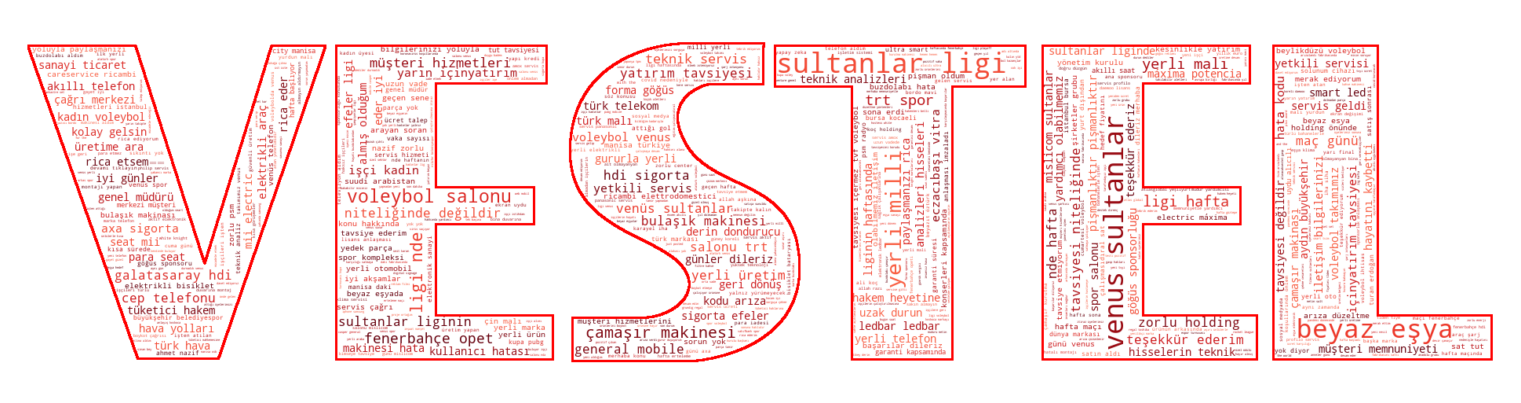

In [19]:

# word frequency sözlüğü oluştur
wordfreq = Counter(bigram_words)
# open the image and use np.array to transform the file to an array
cand_mask=np.array(Image.open('wordcloud_resim/vestel-kirmizi-logo.png'))

# this line will take all values greater than 3 and make them 255 (white)
# if they are less than 3, they will be whatever value they are in the array
cand_mask=np.where(cand_mask > 3, 255, cand_mask)
# import the desired colormap from matplotlib
cmap = mpl.cm.Reds(np.linspace(0,1,20)) 
# the darker part of the matrix is selected for readability
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 
wordcloud = WordCloud(
                      background_color='white',
                      contour_color='red',
                      contour_width=4,
                      mask=cand_mask, 
                      width=900,
                      height=500,
                      max_words=1000,
                      max_font_size=200,
                      relative_scaling=0.5,
                      colormap=cmap,
                      collocations = False, #tekrar eden kelimeler için "false"
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(27,24))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [20]:
dataset_train.head(10)

,Görüş,Durum,Gorus_token
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz,kalitesi ergonomisi rezalet sony aldım fiyatı...
1,hizli teslimat tesekkürler,Tarafsız,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu,olayı süpergece çalıştır sıkıntı yok kablo uz...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz,kulaklığın sesi kaliteli aleti öve öve bitirem...
5,Giriş seviyesindeki kullanıcılar için kabul ed...,Tarafsız,giriş seviyesindeki kullanıcılar kabul edilebi...
6,kullanisli baya,Olumlu,kullanisli baya
7,Dezavantajlar : Pahalı ürün<br />Merhabalar bu...,Tarafsız,dezavantajlar pahalı ürünbr merhabalar lens ba...
8,ÜRÜN GÜZEL BU PARALARA BAŞKA BULAMAZSINIZ,Tarafsız,ürün güzel paralara başka bulamazsiniz
9,Tasarım ve kalite iyi olmasına rağmen yazma hı...,Tarafsız,tasarım kalite iyi olmasına yazma hızı oldukça...


In [21]:

#BAG OF WORDS APPROACH

# feature extraction
bow_vectorizer = CountVectorizer(max_features=1500, ngram_range=(1, 3), min_df=5, max_df=0.7,stop_words=stop_words)


#BOW YERINE TFID KULLANILDI.
bow_x = bow_vectorizer.fit_transform(dataset_train['Gorus_token'])
bow_x = bow_x.toarray()



# transform the entire DataFrame of messages
messages_bow = bow_vectorizer.transform(dataset_train['Gorus_token'])
# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)

tfidfconverter = TfidfTransformer()
tfid_x = tfidfconverter.fit_transform(messages_bow).toarray()
print(tfid_x.shape)

Shape of Sparse Matrix:  (11438, 1500)
(11438, 1500)


##TRAIN VE TEST VERİLERİNİ AYIRMA

In [22]:
model=MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(tfid_x,y_durum,test_size=0.2, random_state = 42)


In [68]:
#classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
#classifier.fit(X_train, y_train) 
#y_pred = classifier.predict(X_test)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [23]:
# training
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train,y_train)

LogisticRegression(max_iter=400)

In [24]:
# testing
y_pred=model.predict(X_test)
cf=classification_report(y_test,y_pred)
print(cf)


              precision    recall  f1-score   support

           0       0.71      0.78      0.74       864
           1       0.49      0.37      0.42       561
           2       0.77      0.82      0.79       863

    accuracy                           0.69      2288
   macro avg       0.66      0.66      0.65      2288
weighted avg       0.68      0.69      0.68      2288



In [25]:
accuracy_score(y_test,y_pred)

0.6940559440559441

In [26]:

# Saving model to disk
pickle.dump(model, open('model_son.pkl','wb'))


In [27]:
# Loading model to compare the results
model = pickle.load(open('model_son.pkl','rb'))

In [28]:

# run predictions on  yorumlar_df DATA
comments_preds = model.predict(bow_vectorizer.transform(yorumlar_df['Text_token']))
# append predictions to dataframe
df_comments_preds = yorumlar_df.copy()
df_comments_preds['predictions'] = comments_preds
df_comments_preds.shape

(82345, 4)

In [29]:
df_comments_preds['sentiment']=df_comments_preds['predictions'].map({0: 'olumsuz',1:'nötr',2:'olumlu'})

In [30]:
df_comments_preds.head()


,Date_time,Text,Text_token,predictions,sentiment
0,02.05.2019 17:55,ötv zamminin arkasinda bu babadagli piyanist ş...,ötv zamminin arkasinda babadagli piyanist şant...,0,olumsuz
1,03.05.2019 00:17 ~ 00:18,çöpünü dahi kullanmadığım ve bundan sonra da k...,çöpünü kullanmadığım kullanmamaya devam edeceğ...,0,olumsuz
2,05.05.2019 22:41,2 buzdolabi2 tv2 camasir mak1 firin 1 supurge ...,buzdolabi camasir mak firin supurge alarak yer...,2,olumlu
3,17.05.2019 16:00,yaklaşık 1 yıl önce sba120 soundbar aldım. ald...,yaklaşık yıl sba soundbar aldım aldığım günden...,1,nötr
4,08.06.2019 14:39,cep telefonlarının dokunmatikleri 2000'li yıll...,cep telefonlarının dokunmatikleri yılların baş...,0,olumsuz


In [31]:
len(df_comments_preds)

82345

In [64]:
#LOAD DATA TO VESTEL.DB SQLLITE DATABASE

df_comments_preds.to_sql('Comments',engine, if_exists='fail')

2021-08-24 22:13:31,433 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Comments")
2021-08-24 22:13:31,435 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-24 22:13:31,436 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Comments")
2021-08-24 22:13:31,437 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-24 22:13:31,441 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-24 22:13:31,442 INFO sqlalchemy.engine.Engine 
CREATE TABLE "Comments" (
	"index" BIGINT, 
	"Date_time" TEXT, 
	"Text" TEXT, 
	"Text_token" TEXT, 
	predictions BIGINT, 
	sentiment TEXT
)


2021-08-24 22:13:31,443 INFO sqlalchemy.engine.Engine [no key 0.00063s] ()
2021-08-24 22:13:31,464 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_Comments_index" ON "Comments" ("index")
2021-08-24 22:13:31,465 INFO sqlalchemy.engine.Engine [no key 0.00083s] ()
2021-08-24 22:13:31,490 INFO sqlalchemy.engine.Engine COMMIT
2021-08-24 22:13:31,544 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-24 22:13:32,300 INF

In [32]:
df_comments_preds.sentiment.value_counts(1).head(10)

olumsuz    0.728508
nötr       0.143834
olumlu     0.127658
Name: sentiment, dtype: float64

Text(0, 0.5, 'Number of Comments')

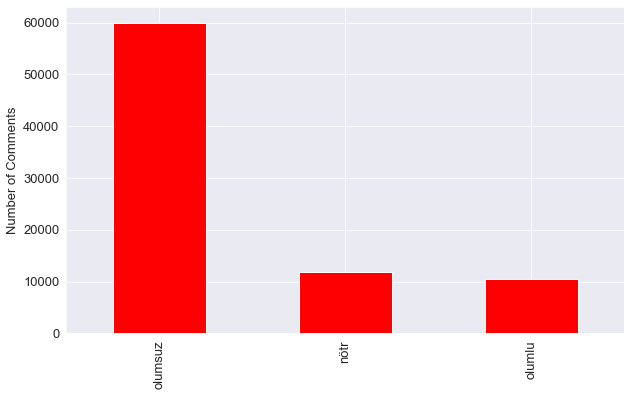

In [33]:
# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df_comments_preds.sentiment.value_counts().head(3)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='Red')
plt.ylabel('Number of Comments', fontsize=13)

([<matplotlib.patches.Wedge at 0x2bff0f29430>,
 [Text(-0.7893467069612965, 0.903842782904946, 'olumsuz'),
  Text(0.3427114473547327, -1.0452506225073603, 'nötr'),
  Text(1.012717006675732, -0.429423176353752, 'olumlu')],
 [Text(-0.4604522457274229, 0.5272416233612185, '72.9%'),
  Text(0.18693351673894507, -0.5701367031858329, '14.4%'),
  Text(0.5523910945503993, -0.23423082346568289, '12.8%')])

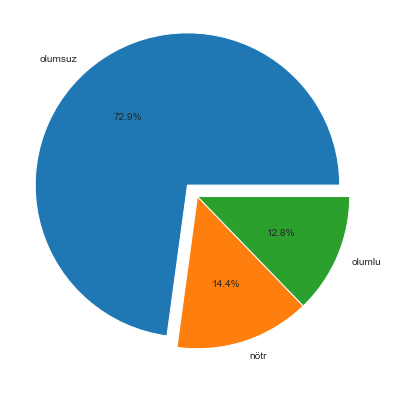

In [34]:
tb_count=  df_comments_preds.sentiment.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_count.values, labels = tb_count.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)


In [35]:
predic_poz = df_comments_preds[ df_comments_preds['predictions'] == 2]
predic_poz=predic_poz['Text_token']
predic_neg = df_comments_preds[ df_comments_preds['predictions'] == 0]
predic_neg = predic_neg['Text_token']
predic_not = df_comments_preds[ df_comments_preds['predictions'] == 1]
predic_not=predic_not['Text_token']

# WORDCLOUD YARATIM

Pozitif kelimeler


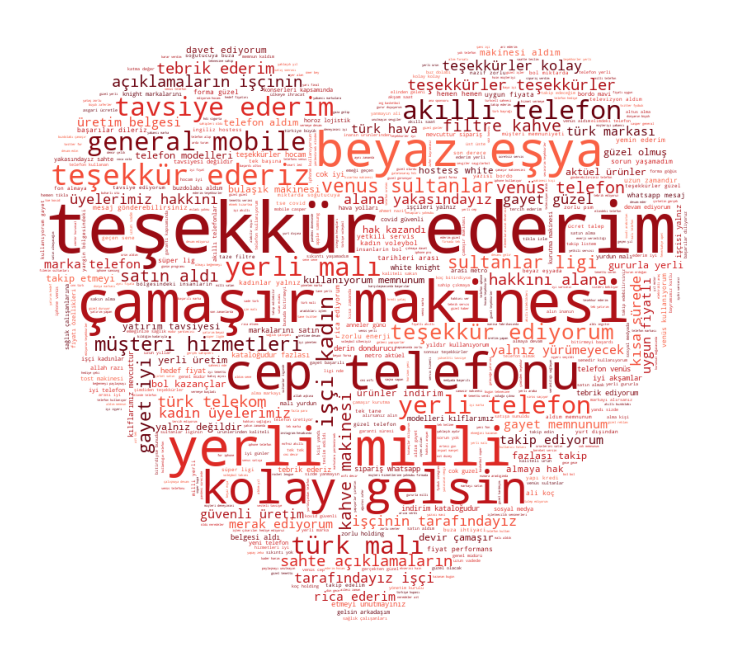

Negatif kelimeler


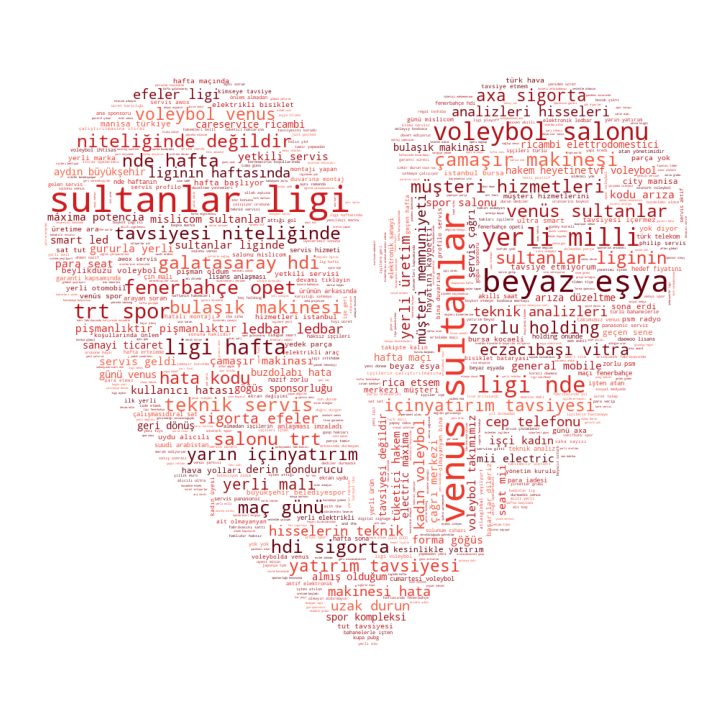

Nötr kelimeler white


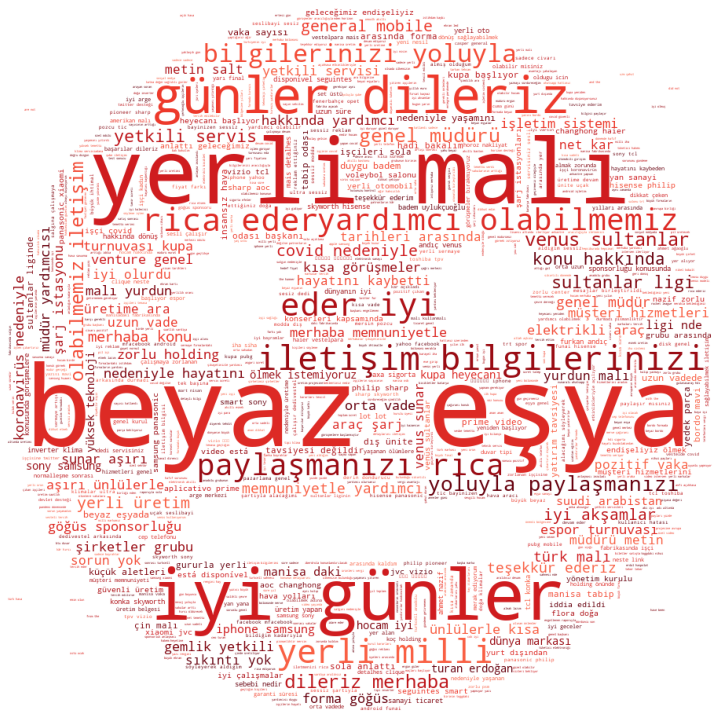

In [36]:
#pos-neg-nötr 
cmap = mpl.cm.Reds(np.linspace(0,1,20)) 
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 
#kaynak:https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis
def wordcloud_draw(data,maskk):
    all_words = []
    for line in list(data):
        words = line.split()
        for word in words:
            all_words.append(word.lower())
    bigrams=ngrams(all_words,2)
    bigram_words = []
    for i, j in bigrams:
         bigram_words.append("{0} {1}".format(i, j))
  
    #maskk=np.where(maskk > 3, 255, maskk)
    wordfreq = Counter(bigram_words)
    wordcloud = WordCloud(
                      background_color='white',
                      mask=maskk,        
                      max_words=1000,
                      max_font_size=200,
                      relative_scaling=0.5,
                      colormap=cmap,
                      stopwords=stop_words,
                      width=2500,
                      height=2000,
                      contour_color='Red',
                      collocations = False #tekrar eden kelimeler için "false"
                     ).generate_from_frequencies(wordfreq)
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
  
cand_mask1=np.array(Image.open('wordcloud_resim/heart.jpeg'))
cand_mask2=np.array(Image.open('wordcloud_resim/broken.jpg'))
cand_mask3=np.array(Image.open('wordcloud_resim/notr.jpg'))
print("Pozitif kelimeler")
wordcloud_draw(predic_poz,cand_mask1)
print("Negatif kelimeler")
wordcloud_draw(predic_neg,cand_mask2)
print("Nötr kelimeler",'white')
wordcloud_draw(predic_not,cand_mask3)